In [2]:
from aleph_alpha_client import Client, SemanticEmbeddingRequest, SemanticEmbeddingResponse, SemanticRepresentation, Prompt, TextControl, Image
from scipy import spatial
import numpy as np
import os
from dotenv import load_dotenv

from langchain.llms import AlephAlpha
from langchain.embeddings import AlephAlphaSymmetricSemanticEmbedding, AlephAlphaAsymmetricSemanticEmbedding

import plotly.express as px
import plotly.graph_objects as go

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [3]:
load_dotenv()

client = Client(token=os.getenv("AA_TOKEN"))

## Let's use luminous embeddings as a classifier

In [12]:
# Here we define two classes that we want to classify
class_1 = ["Find balance in the digital age with mindful technology use and prioritizing self-care.",
"Take charge of your digital wellbeing by setting boundaries and practicing digital detoxes.",
"Promote digital wellbeing through healthy screen time habits and fostering positive online relationships.",
"Explore digital wellbeing apps and tools that help you manage your digital presence and mental health.",
"Prioritize your physical and mental health by practicing digital mindfulness and limiting screen time.",
"Digital wellbeing starts with conscious choices, such as disconnecting from devices and engaging in offline activities.",
]

class_2 = [
    "Digital natives effortlessly navigate the digital landscape, growing up in a world saturated with technology.",
"Born in the digital era, digital natives possess innate digital literacy and adapt quickly to new technologies.",
"Digital natives seamlessly integrate technology into their daily lives, leveraging it for communication, learning, and entertainment.",
"As digital natives, they are the vanguards of technological advancements, shaping the digital landscape with their digital-first mindset.",
"Digital natives are fluent in the language of emojis, hashtags, and memes, using them to express themselves in the digital realm.",
"Growing up surrounded by screens, digital natives are at ease multitasking across multiple devices and platforms.",
]

class_3 = [
    "Digital companies leverage innovative technologies to disrupt traditional industries and drive digital transformation.",
"Agile and data-driven, digital companies thrive in the ever-evolving digital ecosystem, constantly adapting to market demands.",
"Digital companies prioritize user experience, leveraging intuitive interfaces and seamless interactions to engage and retain customers.",
"From e-commerce giants to fintech startups, digital companies revolutionize the way business is conducted in the digital age.",
"Digital companies harness the power of big data and analytics to gain actionable insights and drive informed decision-making.",
"In a borderless digital world, digital companies operate globally, transcending geographical limitations and connecting people worldwide.",
]

### Next we generate embeddings for each class

In [17]:
# TODO: Use the AlephAlpha client to embed the sentences in the two classes
embeddings_class_1 = [client.semantic_embed(SemanticEmbeddingRequest(prompt=Prompt.from_text(text), representation=SemanticRepresentation.Symmetric), model="luminous-base").embedding for text in class_1]
embeddings_class_2 = [client.semantic_embed(SemanticEmbeddingRequest(prompt=Prompt.from_text(text), representation=SemanticRepresentation.Symmetric), model="luminous-base").embedding for text in class_2]
embeddings_class_3 = [client.semantic_embed(SemanticEmbeddingRequest(prompt=Prompt.from_text(text), representation=SemanticRepresentation.Symmetric), model="luminous-base").embedding for text in class_3]

new_sentence = "In order to retain control over you life, you should try to limit your screen time and practice digital mindfulness."
sentence_embedding = client.semantic_embed(SemanticEmbeddingRequest(prompt=new_sentence, representation=SemanticRepresentation.Symmetric), model="luminous-base").embedding

In [18]:
# TODO: get the average similarity of the new sentence to the two classes

similarities_class_1 = [1 - spatial.distance.cosine(sentence_embedding, embedding) for embedding in embeddings_class_1]
similarities_class_2 = [1 - spatial.distance.cosine(sentence_embedding, embedding) for embedding in embeddings_class_2]
similarities_class_3 = [1 - spatial.distance.cosine(sentence_embedding, embedding) for embedding in embeddings_class_3]

# TODO get the average similarity of the new sentence to the two classes
avg_similarity_class_1 = np.mean(similarities_class_1)
avg_similarity_class_2 = np.mean(similarities_class_2)
avg_similarity_class_3 = np.mean(similarities_class_3)

print("Similarity to class 1: ", avg_similarity_class_1)
print("Similarity to class 2: ", avg_similarity_class_2)
print("Similarity to class 3: ", avg_similarity_class_3)

Similarity to class 1:  0.6786340545121642
Similarity to class 2:  0.24306221932952257
Similarity to class 3:  0.1949665787481083


In [ ]:
# Let's use PCA to reduce the dimensionality of the embeddings to 2D

pca = PCA(n_components=2)
pca.fit(embeddings_class_1 + embeddings_class_2 + embeddings_class_3)
pca_embeddings_class_1 = pca.transform(embeddings_class_1)
pca_embeddings_class_2 = pca.transform(embeddings_class_2)
pca_embeddings_class_3 = pca.transform(embeddings_class_3)

# Now let's plot the embeddings from all three classes

fig = go.Figure()

for i, embeddings in enumerate([pca_embeddings_class_1, pca_embeddings_class_2, pca_embeddings_class_3]):

    fig.add_trace(go.Scatter(
        x=embeddings[:,0],
        y=embeddings[:,1],
        mode="markers",
        name=f"Class {i+1}",
        marker=dict(
            size=12,
            color=["red", "green", "blue"][i],
        ),
        text=class_1 + class_2 + class_3,
        hovertemplate=
        "<b>%{text}</b><br><br>" +

        "<i>Similarity to new sentence:</i><br>" +
        "%{marker.color:.2f}<br>" +
        "<extra></extra>"
    ))

    

fig.update_traces(textposition='top center')

fig.show()

### Let's actually train a classifier on these embeddings

In [19]:
# Define a classifier
clf = KNeighborsClassifier(n_neighbors=4)
# use the embeddings and the class labels to train a classifier
X = [np.array(embedding) for embedding in embeddings_class_1 + embeddings_class_2 + embeddings_class_3]
y = np.array([0] * len(embeddings_class_1) + [1] * len(embeddings_class_2) + [2] * len(embeddings_class_3))

# fit the classifier
clf.fit(X, y)

print("Predicted class: ", clf.predict([sentence_embedding]))

Predicted class:  [0]


In [20]:

svm = SVC(kernel='poly', C=1, random_state=42, probability=True)
svm.fit(X, y)

print("Predicted class: ", svm.predict([sentence_embedding]))

# get the probabilities for each class
print("Probabilities: ", svm.predict_proba([sentence_embedding]))

Predicted class:  [0]
Probabilities:  [[0.68430233 0.1126627  0.20303497]]


In [24]:
# aggregate the embeddings of class 1

aggregation_class_1 = np.mean(embeddings_class_1, axis=0)
aggregation_class_2 = np.mean(embeddings_class_2, axis=0)
aggregation_class_3 = np.mean(embeddings_class_3, axis=0)

    

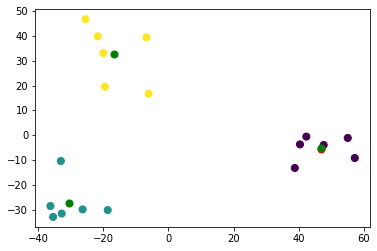

In [28]:
# PCA with three components

pca = PCA(n_components=2)

# fit the PCA to the embeddings
pca.fit(X)

# transform the embeddings
X_pca = pca.transform(X)

pca_agg_class_1 = pca.transform([aggregation_class_1])
pca_agg_class_2 = pca.transform([aggregation_class_2])
pca_agg_class_3 = pca.transform([aggregation_class_3])


# transform the new sentence

sentence_embedding_pca = pca.transform([sentence_embedding])

# plot the embeddings

fig = go.Figure()

for i, embeddings in enumerate([pca_agg_class_1, pca_agg_class_2, sentence_embedding_pca]):

    fig.add_trace(go.Scatter3d(
        x=embeddings[:,0],
        y=embeddings[:,1],
        mode="markers",
        name=f"Class {i+1}",
        marker=dict(
            size=12,
            color=["red", "green", "blue", "yellow"][i],
        ),
        text=class_1 + class_2 + class_3,
        hovertemplate=
        "<b>%{text}</b><br><br>" +

        "<i>Similarity to new sentence:</i><br>" +
        "%{marker.color:.2f}<br>" +
        "<extra></extra>"
    ))


fig.show()

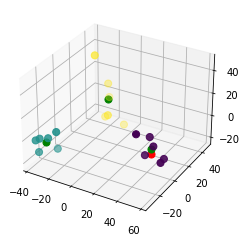

In [29]:
# PCA with three components

pca = PCA(n_components=3)

# fit the PCA to the embeddings
pca.fit(X)

# transform the embeddings
X_pca = pca.transform(X)

pca_agg_class_1 = pca.transform([aggregation_class_1])
pca_agg_class_2 = pca.transform([aggregation_class_2])
pca_agg_class_3 = pca.transform([aggregation_class_3])


# transform the new sentence

sentence_embedding_pca = pca.transform([sentence_embedding])

# plot the embeddings

fig = go.Figure()

for i, embeddings in enumerate([pca_agg_class_1, pca_agg_class_2, pca_agg_class_3, sentence_embedding_pca]):

    fig.add_trace(go.Scatter3d(
        x=embeddings[:,0],
        y=embeddings[:,1],
        z=embeddings[:,2],
        mode="markers",
        name=f"Class {i+1}",
        marker=dict(
            size=12,
            color=["red", "green", "blue", "yellow"][i],
        ),
        text=class_1 + class_2 + class_3,
        hovertemplate=
        "<b>%{text}</b><br><br>" +

        "<i>Similarity to new sentence:</i><br>" +
        "%{marker.color:.2f}<br>" +
        "<extra></extra>"
    ))


fig.show()